In [2]:
!pip install --upgrade pip
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets 
!pip install git+https://github.com/huggingface/transformers
!pip install sentencepiece
!pip install git+https://github.com/salaniz/pycocoevalcap


  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-pye5r56e
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-pye5r56e
  Resolved https://github.com/huggingface/transformers to commit d6751d91c8f58cdeb35af6adae182d7dc90aa883
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-fz8dl8zz
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-fz8dl8zz
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done


In [3]:
import os
import base64
import torch
import pickle
from PIL import Image
from io import BytesIO
from torch.utils.data import DataLoader, random_split
from transformers import Blip2Processor, Blip2ForConditionalGeneration, AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import json
from PIL import Image
from torch.utils.data import Dataset

# Load the BLIP2 model and processor
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

2024-08-15 19:50:54.500474: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 19:50:54.542657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 19:50:54.542708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 19:50:54.543830: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 19:50:54.550804: I tensorflow/core/platform/cpu_feature_guar

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [4]:

import json
import os
from PIL import Image
from torch.utils.data import Dataset
from transformers import AutoProcessor

import json
from PIL import Image
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, json_file, processor, image_size=(512, 512)):
        self.processor = processor
        self.image_size = image_size
        with open(json_file, 'r') as f:
            data = json.load(f)
            self.images = data['images']
            self.annotations = {ann['image_id']: ann['caption'] for ann in data['annotations']}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = img_info['file_name']
        image = Image.open(img_path).convert("RGB")
        image = image.resize(self.image_size)

        caption = self.annotations.get(img_info['id'], "")  # Default to empty string if not found
        encoding = self.processor(images=image, padding="max_length", return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = caption
        return encoding


def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key == "text":
            texts = [example["text"] for example in batch]
            text_inputs = processor.tokenizer(
                texts,
                padding="max_length",
                max_length=300,  # Ensure this matches the expected length
                return_tensors="pt",
                truncation=True,
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
        else:
            processed_batch[key] = torch.stack([example[key] for example in batch])
    return processed_batch



In [5]:

# Define file paths
val_json = 'chart-to-text_val1.json'
train_json = 'chart-to-text_train1.json'
test_json = 'chart-to-text_test1.json'


# Create datasets
train_dataset = ImageCaptioningDataset(train_json, processor)
val_dataset = ImageCaptioningDataset(val_json,processor)
test_dataset = ImageCaptioningDataset(test_json,processor)

print(("train_dataset_len",len(train_dataset),"val_dataset_len",len(val_dataset),"test_dataset_len",len(test_dataset)))
      
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn)


('train_dataset_len', 39686, 'val_dataset_len', 2204, 'test_dataset_len', 2206)


In [1]:
import matplotlib.pyplot as plt
from pycocoevalcap.cider.cider import Cider
from tqdm import tqdm
import torch
import pickle

# Define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1, gamma=0.90)

# Training parameters
num_epochs = 10
patience = 3
min_eval_loss = float("inf")
early_stopping_hook = 0
tracking_information = []
train_losses = []
eval_losses = []

# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()

    for idx, batch in enumerate(tqdm(train_loader, desc='Training batch: ...')):
        input_ids = batch['input_ids'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        captions = batch['input_ids'].to(device)  # Use input_ids as target outputs

        optimizer.zero_grad()  # Zero gradients at the start of each batch
        torch.cuda.empty_cache()  # Optionally, clear cache to manage memory

        # Ensure the model's forward pass is correctly handling inputs
        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=captions)  # Assuming labels are the same as input_ids for language models

        loss = outputs.loss
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation loop for validation data
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating batch: ...'):
            input_ids = batch['input_ids'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            captions = batch['input_ids'].to(device)  # Use input_ids as target outputs

            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=captions)  # Assuming labels are the same as input_ids

            loss = outputs.loss
            eval_loss += loss.item()

    avg_eval_loss = eval_loss / len(val_loader)
    eval_losses.append(avg_eval_loss)

    tracking_information.append((avg_train_loss, avg_eval_loss, optimizer.param_groups[0]["lr"]))
    print(f"Epoch: {epoch + 1} - Training loss: {avg_train_loss:.4f} - Eval Loss: {avg_eval_loss:.4f} - LR: {optimizer.param_groups[0]['lr']:.6f}")
   
    scheduler.step()
    
    # Save the best model based on validation loss
    try:
        if avg_eval_loss < min_eval_loss:
            torch.save(model.state_dict(), 'best_model_c2t.pth') 
            print("Saved model to best_model.pth")
            min_eval_loss = avg_eval_loss
            early_stopping_hook = 0
        else:
            early_stopping_hook += 1
            if early_stopping_hook > patience:
                print(f"Learning rate decayed to: {optimizer.param_groups[0]['lr']:.6f}")
                early_stopping_hook = 0  # Reset early stopping hook after learning rate decay

            if early_stopping_hook > patience:
                print("Early stopping triggered")
                break
        # Save the last model
        torch.save(model.state_dict(), 'last_model_c2t.pth')
    except Exception as e:
        print(f"Error saving the model: {e}")

# Save tracking information
with open("tracking_information_final_caption128.pkl", "wb") as f:
    pickle.dump(tracking_information, f)
print("The finetuning process has completed!")

epochs_completed = len(train_losses)

plt.figure(figsize=(14, 6))

# Plot Losses
plt.plot(range(1, epochs_completed + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs_completed + 1), eval_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('caption_loss_plot.png')  # Save the plot as a .png file
plt.show()  # Show the plot


In [8]:
import torch
from tqdm import tqdm
import numpy as np
from pycocoevalcap.cider.cider import Cider

def evaluate(model, loader, processor, device, num_examples=5, num_beams=7):
    model.eval()
    total_loss = 0
    num_batches = 0
    all_labels = []
    all_preds = []

    # List to store some example inputs and their predictions
    example_inputs = []
    example_predictions = []

    # Collecting predictions and ground truth captions for CIDEr
    results = []
    gts = {}

    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating batch:'):
            input_ids = batch['input_ids'].squeeze(1).to(device)
            pixel_values = batch['pixel_values'].squeeze(1).to(device)
            labels = batch['input_ids'].to(device)  # Assuming 'labels' contains ground truth captions
            
            # Ensure the model is on the correct device
            model.to(device)
            
            # Clear cache to reduce memory usage
            # torch.cuda.empty_cache()

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            num_batches += 1

            # Generate predictions using num_beams for better quality
            preds = model.generate(pixel_values, max_length=300, num_beams=num_beams)
            preds_decoded = processor.batch_decode(preds, skip_special_tokens=True)
            labels_decoded = processor.batch_decode(labels, skip_special_tokens=True)
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

            # Collect some example inputs and predictions
            if len(example_inputs) < num_examples:
                example_inputs.extend(input_ids.cpu().numpy())
                example_predictions.extend(preds.cpu().numpy())

            # Prepare data for CIDEr evaluation
            for i in range(len(labels)):
                image_id = f"batch{num_batches}_img{i}"
                model_answer = preds_decoded[i]
                annotator_answer = labels_decoded[i]
                results.append({"image_id": image_id, "caption": model_answer})
                if image_id not in gts:
                    gts[image_id] = []
                gts[image_id].append(annotator_answer)

    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    average_loss = total_loss / num_batches

    # Calculate CIDEr score
    cider_scorer = Cider()
    
    # Prepare results and ground truth dictionaries for scoring
    results_dict = {item['image_id']: [item['caption']] for item in results}
    cider_score, _ = cider_scorer.compute_score(gts, results_dict)

    # Print example inputs and predictions
    for i in range(min(num_examples, len(example_inputs))):
        input_text = processor.tokenizer.decode(example_inputs[i], skip_special_tokens=True)
        predicted_label = processor.tokenizer.decode(example_predictions[i], skip_special_tokens=True)
        print(f"Input: {input_text}")
        print(f"Predicted Label: {predicted_label}")
        print()

    return average_loss, cider_score

# Load the best model for final evaluation
model.load_state_dict(torch.load('last_model_c2t.pth'))

# Final Evaluation on Test Set
test_loss, test_cider = evaluate(model, test_loader, processor, device, num_beams=7)
print(f"Test Loss: {test_loss:.4f}, CIDEr Score: {test_cider:.4f}")


Evaluating batch:: 100%|██████████| 736/736 [2:40:39<00:00, 13.10s/it]  


Input:  This statistic shows the per capita personal income in Utah from 2000 to 2019. In 2019, the per capita personal income in Utah was 48,939 U.S. dollars. Personal income is the income that is received by persons from all sources. 
Predicted Label:  This statistic shows the per capita personal income in North Carolina from 2000 to 2019. In 2019, the per capita personal income in North Carolina was 49,934 U.S. dollars. Personal income is the income that is received by persons from all sources. 

Input:  The average price of an acrylic fill in nail salons in the United States came at just under 30 U.S. dollars in 2019. Many different types of manicures are offered at nail salons. One type of manicure is the acrylic nail. Acrylic nails are made by mixing liquid monomer a with powder polymer, which are shaped to the clientâ€™s nail. When applied to the clientâ€™s nails, they become hard and strong. Nail salons in the U.S. A nail salon is a type of beauty salon that focuses primarily o

# Code to use the model 

Generated Sumamry:  This statistic shows the per capita personal income in North Carolina from 2000 to 2019. In 2019, the per capita personal income in North Carolina was 49,934 U.S. dollars. Personal income is the income that is received by persons from all sources.


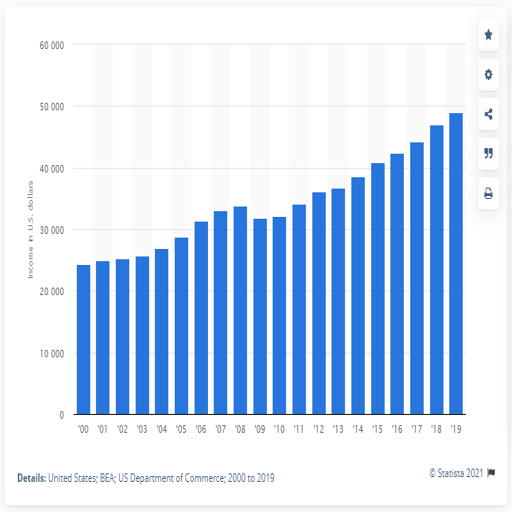

In [10]:
from PIL import Image
import torch
model.to(device)
# Load a single image
image_path = 'out/two_col/imgs/25669.png'  # Specify the path to your image
image = Image.open(image_path).convert("RGB")

model.load_state_dict(torch.load('last_model_c2t.pth'))
inputs = processor(images=image, return_tensors="pt").to(device)

generated_ids = model.generate(**inputs, max_length=300, num_beams=7)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print("Generated Sumamry: ",generated_text)
image.resize((512, 512))
